# Visualize LIBERO Dataset

In [41]:
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]


Libraries

In [42]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D proj)
from mpl_toolkits.mplot3d import art3d  # Line3DCollection lives here
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE














































































Load Dataset

In [22]:
# tfrecord_dir = "/home/ubuntu/vla/data/modified_libero_rlds/libero_spatial_no_noops/1.0.0"
# tfrecord_dir = "/home/ubuntu/vla/data/closed_gripper_libero_rlds/libero_spatial_no_noops/1.0.0"
tfrecord_dir = "/home/ubuntu/vla/data/k_7_clustered_14000_libero_rlds/libero_spatial_no_noops/1.0.0"

tfrecord_paths = [
    os.path.join(tfrecord_dir, f)
    for f in sorted(os.listdir(tfrecord_dir))
    if ".tfrecord" in f
]
tfrecord_paths

['/home/ubuntu/vla/data/k_7_clustered_14000_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00000-of-00016',
 '/home/ubuntu/vla/data/k_7_clustered_14000_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00001-of-00016',
 '/home/ubuntu/vla/data/k_7_clustered_14000_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00002-of-00016',
 '/home/ubuntu/vla/data/k_7_clustered_14000_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00003-of-00016',
 '/home/ubuntu/vla/data/k_7_clustered_14000_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00004-of-00016',
 '/home/ubuntu/vla/data/k_7_clustered_14000_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00005-of-00016',
 '/home/ubuntu/vla/data/k_7_clustered_14000_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00006-of-00016',
 '/home/ubuntu/vla/data/k_7_clustered_14000_libero_rlds/libero_spatia

In [23]:
# === Load all episodes into a list first ===
raw_dataset = list(tf.data.TFRecordDataset(tfrecord_paths))
total_episodes = len(raw_dataset)
print(f"Total episodes in file: {total_episodes}")

Total episodes in file: 14000


Gather Trajectories

[Success] Saved plot to all_trajectories_xyz.png


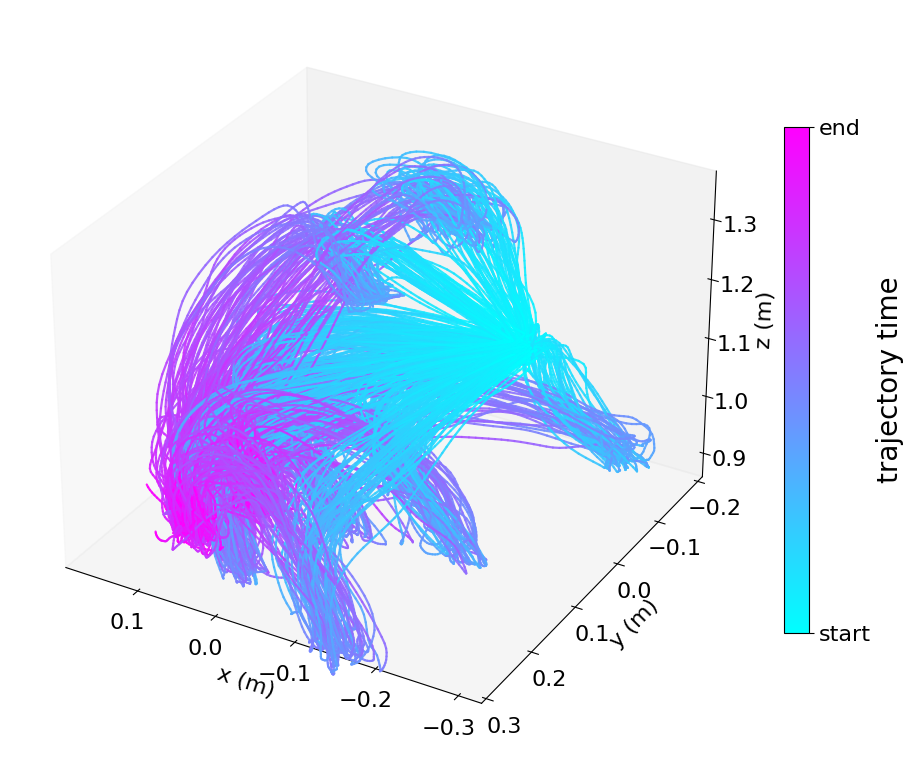

In [21]:
# --- knobs ---
TEXT_SIZE = 20
# Closed gripper when action[-1] == 1.0
OVERLAY_GRIPPER_CLOSE = False          # <== turn overlay on/off here
SUNSET_ORANGE = "#FF1100E4"             # sunset-ish orange

def get_xyz_position_from_episode(context):
    state_flat = context["steps/observation/state"].float_list.value
    state = np.asarray(state_flat, dtype=np.float32).reshape(-1, 8)
    return state[:, :3]

def get_actions_from_episode(context):
    action_flat = context["steps/action"].float_list.value
    return np.asarray(action_flat, dtype=np.float32).reshape(-1, 7)

def set_axes_equal(ax):
    xlim, ylim, zlim = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
    ranges = np.array([xlim, ylim, zlim])
    centers = ranges.mean(axis=1)
    max_range = (ranges[:,1] - ranges[:,0]).max() / 3
    ax.set_xlim3d([centers[0]-max_range, centers[0]+max_range])
    ax.set_ylim3d([centers[1]-max_range, centers[1]+max_range])
    ax.set_zlim3d([centers[2]-max_range, centers[2]+max_range])

def add_gradient_line(ax, xyz, cmap):
    if len(xyz) < 2:
        return
    segs = np.stack([xyz[:-1], xyz[1:]], axis=1)
    t = np.linspace(0, 1, len(segs))
    norm = mpl.colors.Normalize(0, 1)

    lc = art3d.Line3DCollection(segs, cmap=cmap, norm=norm)
    lc.set_array(t)
    lc.set_linewidth(1.6)
    lc.set_alpha(0.9)
    lc.set_capstyle("round")
    lc.set_joinstyle("round")
    ax.add_collection3d(lc)

def add_overlay_closed(ax, xyz, closed_mask, color=SUNSET_ORANGE, lw=2.2, alpha=0.9):
    """Overlay solid color segments where gripper is closed.
       closed_mask: (T,) bool for each timestep."""
    if len(xyz) < 2:
        return
    segs_all = np.stack([xyz[:-1], xyz[1:]], axis=1)
    seg_mask = closed_mask[:-1]  # segment starts at t
    segs = segs_all[seg_mask]
    if len(segs) == 0:
        return
    lc = art3d.Line3DCollection(segs)
    lc.set_color(color)
    lc.set_linewidth(lw)
    lc.set_alpha(alpha)
    lc.set_capstyle("round")
    lc.set_joinstyle("round")
    ax.add_collection3d(lc)

# ---------- Plot ----------
mpl.rcParams.update({
    "axes.grid": False,
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
    "font.size": TEXT_SIZE
})
cmap = plt.colormaps.get_cmap("cool")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

for ep in range(total_episodes):
    raw_record = raw_dataset[ep]
    example = tf.train.SequenceExample(); example.ParseFromString(raw_record.numpy())
    context = example.context.feature

    xyz = get_xyz_position_from_episode(context)
    add_gradient_line(ax, xyz, cmap)

    if OVERLAY_GRIPPER_CLOSE:
        actions = get_actions_from_episode(context)
        # Closed gripper when action[-1] == 1.0
        closed = np.isclose(actions[:, -1], 1.0)
        add_overlay_closed(ax, xyz, closed)
    
# Clean look
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis._axinfo["grid"]["linewidth"] = 0

ax.set_xlabel("x (m)", fontsize=TEXT_SIZE-4)
ax.set_ylabel("y (m)", fontsize=TEXT_SIZE-4)
ax.set_zlabel("z (m)", fontsize=TEXT_SIZE-4)
ax.tick_params(labelsize=TEXT_SIZE-4)
set_axes_equal(ax)

# --- Colorbar for gradient ---
norm = mpl.colors.Normalize(0, 1)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_ticks([0, 1]); cbar.set_ticklabels(["start", "end"])
cbar.set_label("trajectory time", fontsize=TEXT_SIZE)
cbar.ax.tick_params(labelsize=TEXT_SIZE-4)

# Optional legend for overlay example
if OVERLAY_GRIPPER_CLOSE:
    overlay_handle = mpl.lines.Line2D([0], [0], color=SUNSET_ORANGE, lw=3, label="gripper closed")
    ax.legend(handles=[overlay_handle], loc="upper right", fontsize=TEXT_SIZE-4, title_fontsize=TEXT_SIZE-2)

ax.view_init(azim=120)
plt.tight_layout()
plt.savefig("all_trajectories_xyz.png", dpi=300)
print("[Success] Saved plot to all_trajectories_xyz.png")


Data Analysis of Percent of Trajectory Gripper is Closed

The average percent of steps gripper is closed: 53.73%
[Success] Saved plot to gripper_closed_distribution.png


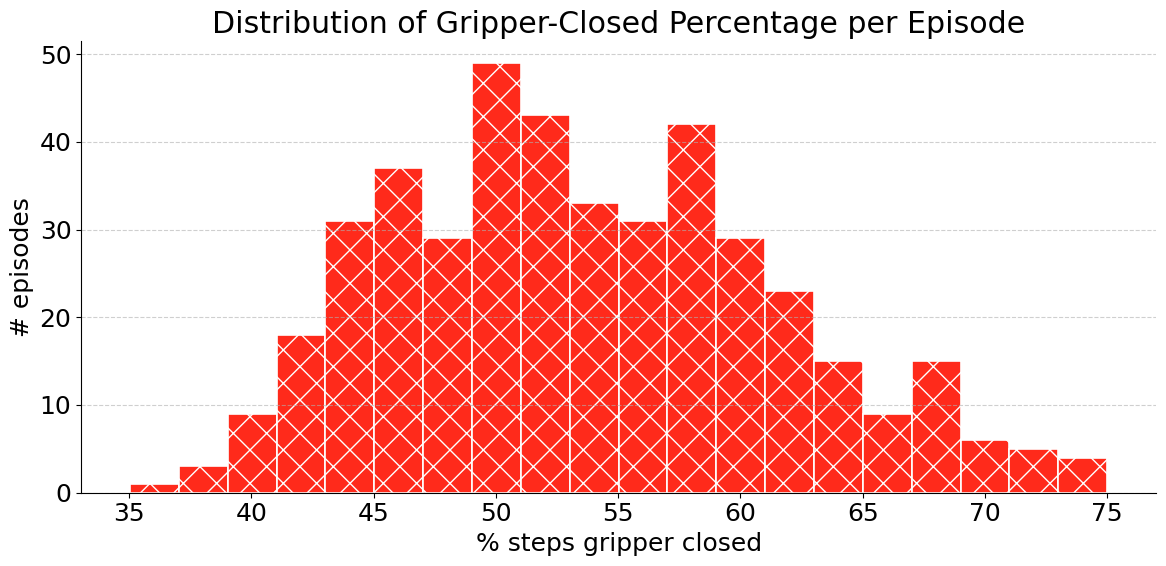

In [ ]:
closed_pct = []
for ep in range(total_episodes):
    raw_record = raw_dataset[ep]
    example = tf.train.SequenceExample(); example.ParseFromString(raw_record.numpy())
    context = example.context.feature

    actions = get_actions_from_episode(context)
    closed = np.isclose(actions[:, -1], 1.0)

    closed_pct.append(closed.mean() * 100.0)

p = np.array(closed_pct)

print(f"The average percent of steps gripper is closed: {p.mean():.2f}%")

TEXT = 18
ORANGE = "#FF1100E4"
HATCH = "/\\"

# plot
plt.rcParams.update({'font.size': TEXT, 'figure.facecolor': 'white', 'savefig.facecolor': 'white'})
fig, ax = plt.subplots(figsize=(12, 6))
counts, bins, patches = ax.hist(p, bins=20, edgecolor='white', linewidth=1.2, color=ORANGE)
for bar in patches: bar.set_hatch(HATCH)

ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines[['top', 'right']].set_visible(False)
ax.set(xlabel='% steps gripper closed', ylabel='# episodes',
       title='Distribution of Gripper-Closed Percentage per Episode')

plt.tight_layout()
plt.savefig('gripper_closed_distribution.png', dpi=300, bbox_inches='tight')
print('[Success] Saved plot to gripper_closed_distribution.png')

# K-means Clustering

In [ ]:
# Collect all states across episodes ---
states_list = []
for ep in range(total_episodes):
    raw_record = raw_dataset[ep]
    ex = tf.train.SequenceExample()
    ex.ParseFromString(raw_record.numpy())
    ctx = ex.context.feature

    state_flat = ctx["steps/observation/state"].float_list.value
    state = np.asarray(state_flat, dtype=np.float32).reshape(-1, 8)
    states_list.append(state)

# Stack into one array of shape (total_steps, 8)
states_all = np.vstack(states_list)
print(f"Collected {states_all.shape[0]} total state vectors.")

Calculate Inertias to find beyond what K you get Diminishing returns

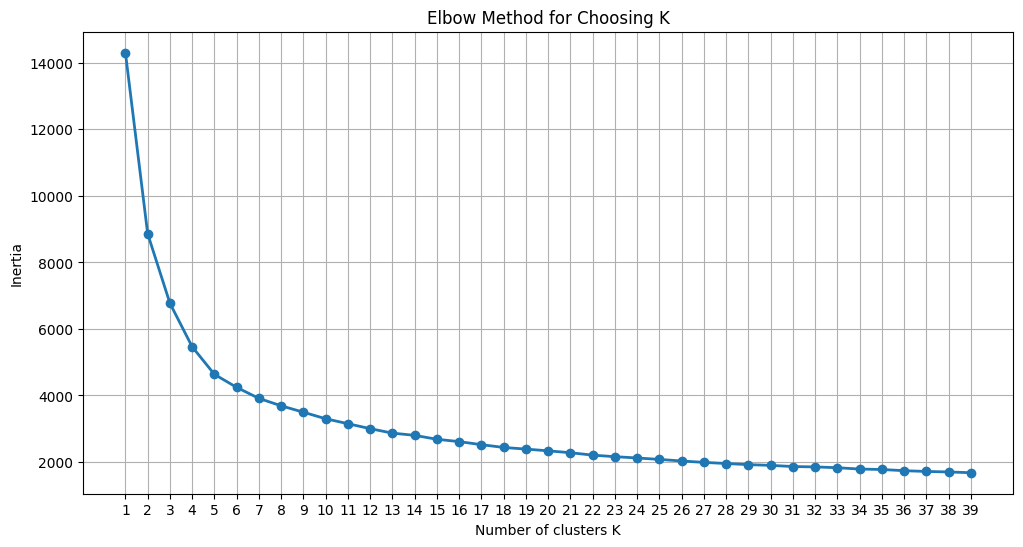

In [ ]:
inertias = []
Ks = range(1, 40)
for k in Ks:
    km = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(states_all)
    inertias.append(km.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(Ks, inertias, 'o-', linewidth=2)
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia")
plt.title("Elbow Method for Choosing K")
plt.xticks(Ks)
plt.grid(True)
plt.show()


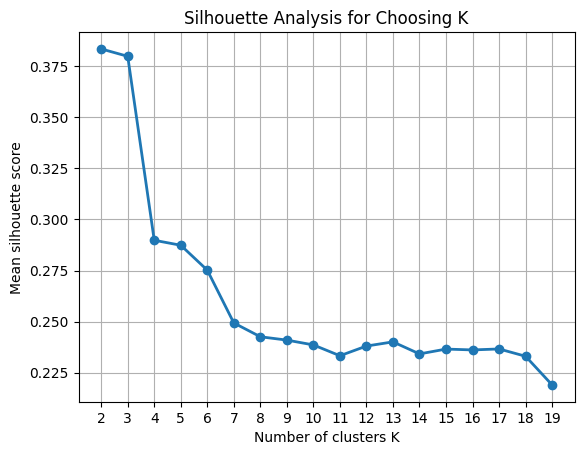

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []
Ks = range(2, 20)    # silhouette isn’t defined for K=1
for k in Ks:
    km = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(states_all)
    labels = km.labels_
    sil_scores.append(silhouette_score(states_all, labels))

plt.plot(Ks, sil_scores, 'o-', linewidth=2)
plt.xlabel("Number of clusters K")
plt.ylabel("Mean silhouette score")
plt.title("Silhouette Analysis for Choosing K")
plt.xticks(Ks)
plt.grid(True)
plt.show()

In [ ]:
# Normalize features
# scaler = StandardScaler()
# states_norm = scaler.fit_transform(states_all)

# Run k-means clustering ---
K = 7  # choose number of clusters
kmeans = KMeans(n_clusters=K, init="k-means++", random_state=0)
labels = kmeans.fit_predict(states_all)
print("Cluster counts:", np.bincount(labels))

# t-SNE visualization of clusters ---
tsne = TSNE(n_components=2, random_state=0)
states_2d = tsne.fit_transform(states_all)

Cluster counts: [11443  6242  4183  3913 13822  5536  7831]


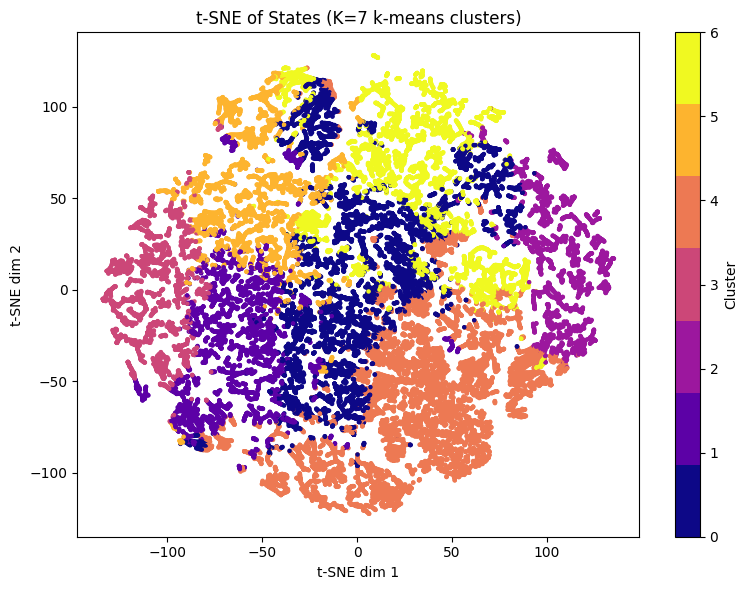

In [ ]:
K = labels.max() + 1
cmap = plt.get_cmap("plasma", K)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(states_2d[:,0], states_2d[:,1], c=labels, cmap=cmap, s=5, vmin=0, vmax=K-1,)
plt.title(f"t-SNE of States (K={K} k-means clusters)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.colorbar(scatter, ticks=range(K), label="Cluster")
plt.tight_layout()
plt.savefig("tsne_states_clusters.png", dpi=300)

# Plot Clustered Dataset

Once you have used the data selector to create a clusted dataset you can visualize them here

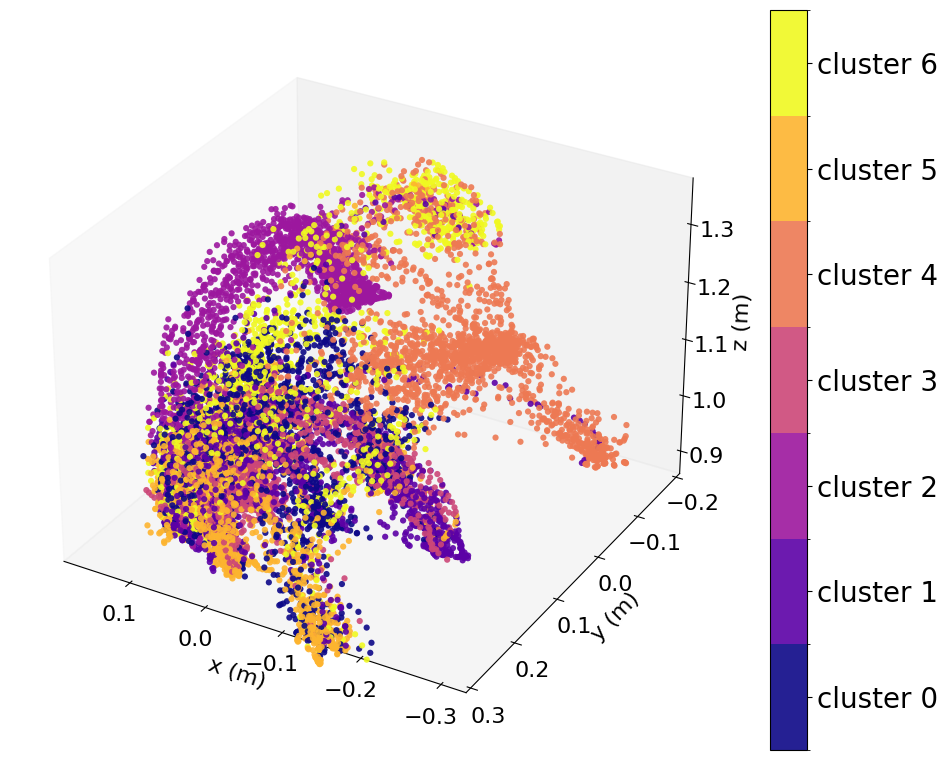

In [30]:
from matplotlib.colors import BoundaryNorm

def get_cluster_ids_from_episode(context):
    """Get cluster IDs from context, if available."""
    if "cluster_id" in context:
        cluster_flat = context["cluster_id"].int64_list.value
        return np.asarray(cluster_flat, dtype=np.int32)
    else:
        return None

cmap   = plt.get_cmap('plasma', 7)                   # 7 discrete colours
bounds = np.arange(-0.5, 7.5, 1)                     # make 7 bins centred on 0,1,…,6
norm   = BoundaryNorm(boundaries=bounds, ncolors=7)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

for ep in range(total_episodes):
    raw_record = raw_dataset[ep]
    example = tf.train.SequenceExample(); example.ParseFromString(raw_record.numpy())
    context = example.context.feature

    xyz = get_xyz_position_from_episode(context)
    cluster_id = get_cluster_ids_from_episode(context)
    if cluster_id is None:
        continue

    sc = ax.scatter(
        xyz[:,0], xyz[:,1], xyz[:,2],
        c=cluster_id,
        cmap=cmap,
        norm=norm,
        s=20,
        alpha=0.9,
        edgecolors="none"
    )
    
# Clean look
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis._axinfo["grid"]["linewidth"] = 0

ax.set_xlabel("x (m)", fontsize=TEXT_SIZE-4)
ax.set_ylabel("y (m)", fontsize=TEXT_SIZE-4)
ax.set_zlabel("z (m)", fontsize=TEXT_SIZE-4)
ax.tick_params(labelsize=TEXT_SIZE-4)
set_axes_equal(ax)

# add colorbar
cbar = fig.colorbar(sc, ax=ax, boundaries=bounds, ticks=np.arange(7))
cbar.set_ticklabels([f'cluster {i}' for i in range(7)])

ax.view_init(azim=120)
plt.tight_layout()
plt.savefig("clustered_states_xyz.png", dpi=300)
plt.show()


Analyze the clusters

In [38]:
cluster_task_dict = {}

for ep in range(total_episodes):
    raw_record = raw_dataset[ep]
    example = tf.train.SequenceExample(); example.ParseFromString(raw_record.numpy())
    context = example.context.feature

    cluster_id = get_cluster_ids_from_episode(context)
    if cluster_id is None:
        continue
    cid = int(cluster_id[0])

    instr = context["steps/language_instruction"].bytes_list.value[0].decode("utf-8")

    # ← instead of overwriting, append into a list:
    cluster_task_dict.setdefault(cid, []).append(instr)


/tmp/ipykernel_515984/3386930592.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


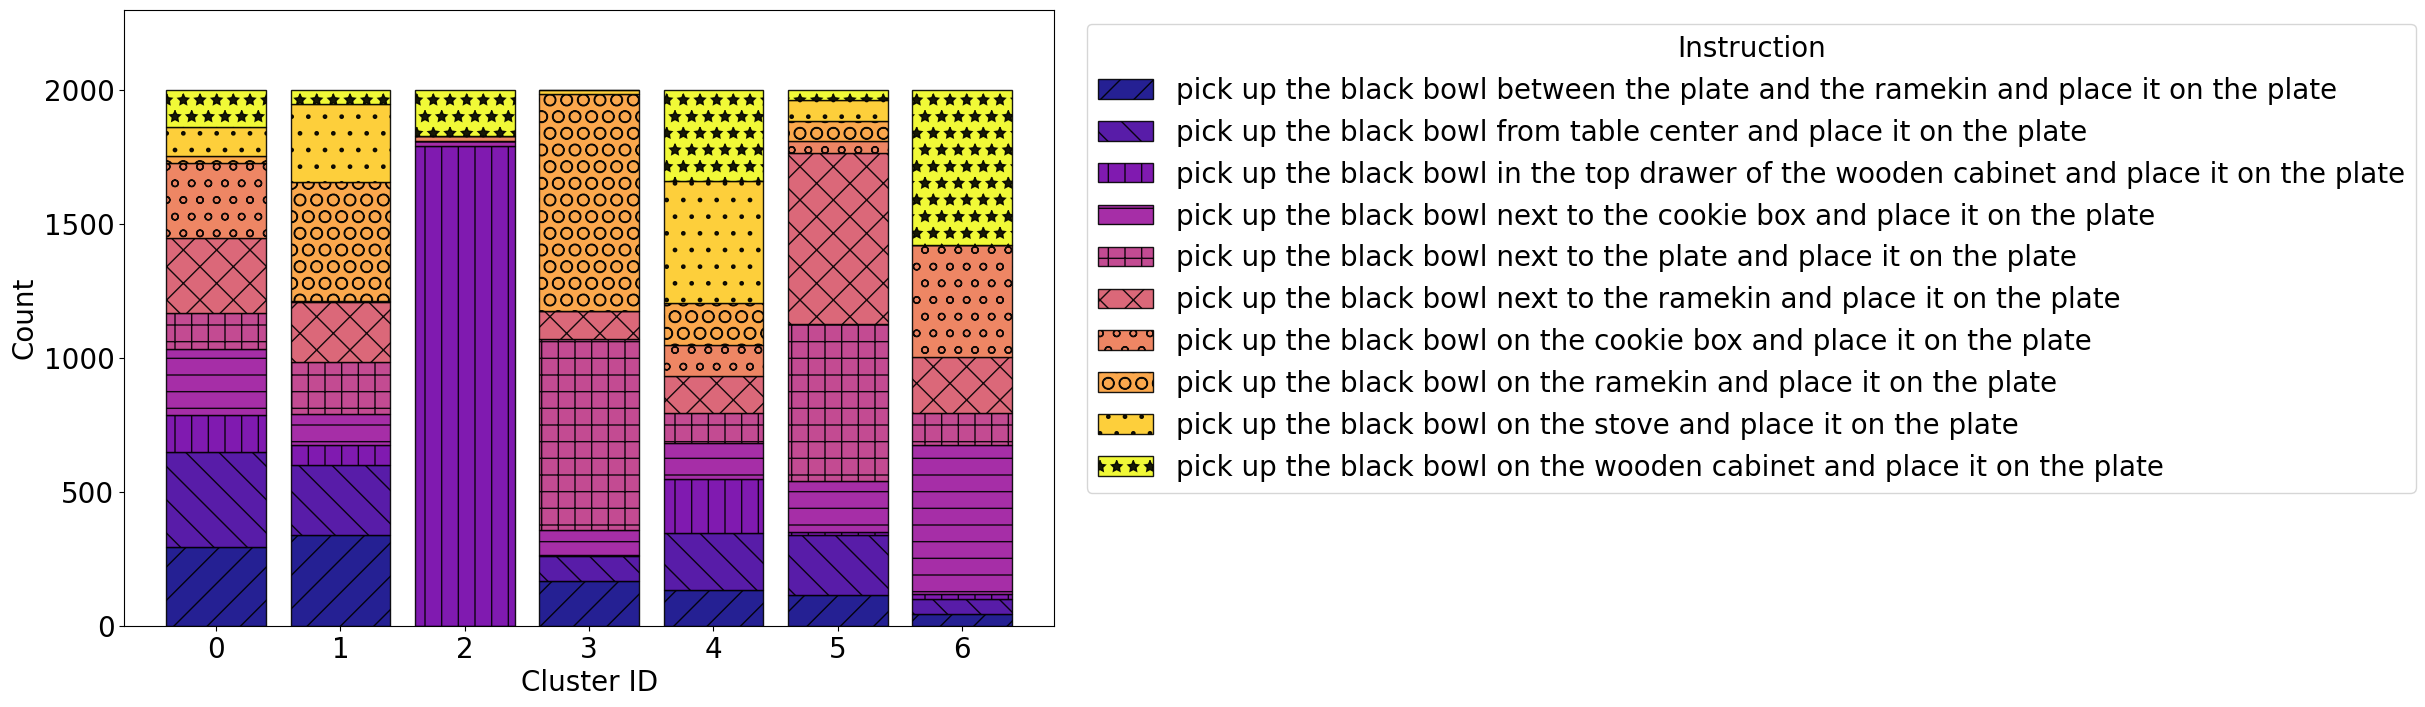

In [49]:
# 1) Turn it into a long DataFrame
rows = []
for cid, instrs in cluster_task_dict.items():
    for instr in instrs:
        rows.append((cid, instr))
df = pd.DataFrame(rows, columns=["cluster_id", "instruction"])

# 2) Count how many times each instruction appears in each cluster
counts = df.groupby(["cluster_id", "instruction"]).size().unstack(fill_value=0)

clusters = counts.index
instr_names = counts.columns.tolist()

# get N distinct plasma colors
cmap = plt.get_cmap("plasma")
colors = cmap(np.linspace(0, 1, len(instr_names)))

# a list of hatch patterns (you can customize/order as you like)
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

fig, ax = plt.subplots(figsize=(12, 8))
bottom = np.zeros(len(clusters))

for i, instr in enumerate(instr_names):
    vals = counts[instr].values
    ax.bar(
        clusters,
        vals,
        bottom=bottom,
        label=instr,
        color=colors[i],
        hatch=hatches[i % len(hatches)],
        width=0.8,
        edgecolor='black',   # often nicer with a black edge
        alpha=0.9
    )
    bottom += vals

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Count")
ax.set_xticks(clusters)
ax.legend(title="Instruction", bbox_to_anchor=(1.02,1), loc="upper left")
ax.set_ylim(0, 2300)
plt.tight_layout()
plt.savefig("cluster_instruction_distribution.png", dpi=300, bbox_inches='tight')
plt.show()